Install and import modules

In [1]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import io #to load uploaded data
from bertopic import BERTopic


In [2]:
#load data
from google.colab import files
uploaded = files.upload()

Saving kc_wiki_with_summary.csv to kc_wiki_with_summary.csv


In [5]:
#load wiki data with summary for KC
kc_wiki_with_summary= pd.read_csv(io.BytesIO(uploaded['kc_wiki_with_summary.csv']))

In [6]:
import geopandas as gpd
#select certain columns from wiki data
kc_wiki = kc_wiki_with_summary[["gt_page_id",
                   "gt_lon",
                   "gt_lat",
                   "geometry",
                   "page_title",
                   "page_summary"]]
#set geometry for wiki data
kc_wiki = gpd.GeoDataFrame(kc_wiki,
                           geometry=gpd.points_from_xy(kc_wiki.gt_lon,
                                                       kc_wiki.gt_lat),
                                                       crs="EPSG:4326")

In [ ]:
#pre-process data
#reference for gensim library https://www.kaggle.com/code/venkatkrishnan/gensim-text-mining-techniques
#https://radimrehurek.com/gensim/parsing/preprocessing.html
#pd.set_option('display.max_colwidth', 1)
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, strip_punctuation, remove_stopwords, strip_short
transform_to_lower = lambda s: s.lower()
filters = [strip_tags,
           strip_numeric,
          transform_to_lower,
          strip_punctuation,
          strip_multiple_whitespaces,
          remove_stopwords,
          strip_short
          ]

def cleaning_text(document):
    clean_text = preprocess_string(document, filters)
    return clean_text

kc_wiki_with_summary['clean_summary'] = kc_wiki_with_summary['page_summary'].apply(cleaning_text)

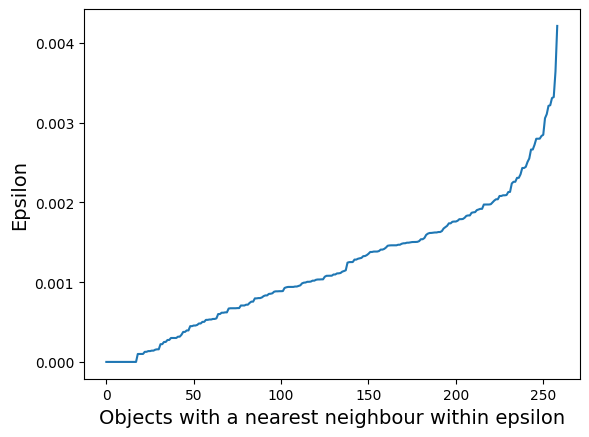

In [7]:
from shapely.geometry import MultiPoint
#load data
kc_coords = kc_wiki[['gt_lon', 'gt_lat']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Objects with a nearest neighbour within epsilon', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

In [8]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0020, min_samples=5)
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_wiki['cluster'] = dbscan_labels

no. of clusters: 15
no of noise: 130


[<POLYGON ((-0.184 51.499, -0.19 51.499, -0.194 51.501, -0.193 51.503, -0.193...>, <POLYGON ((-0.172 51.488, -0.175 51.488, -0.175 51.488, -0.175 51.489, -0.17...>, <POLYGON ((-0.182 51.492, -0.184 51.493, -0.183 51.495, -0.183 51.495, -0.18...>, <POLYGON ((-0.165 51.486, -0.17 51.487, -0.168 51.488, -0.165 51.49, -0.164 ...>, <POLYGON ((-0.178 51.485, -0.179 51.485, -0.18 51.486, -0.181 51.488, -0.181...>, <POLYGON ((-0.161 51.495, -0.16 51.497, -0.159 51.499, -0.159 51.499, -0.158...>, <POLYGON ((-0.173 51.482, -0.175 51.483, -0.175 51.484, -0.174 51.486, -0.17...>, <POLYGON ((-0.163 51.484, -0.166 51.484, -0.164 51.484, -0.163 51.484, -0.16...>, <POLYGON ((-0.173 51.496, -0.174 51.496, -0.176 51.498, -0.17 51.497, -0.173...>, <POLYGON ((-0.168 51.494, -0.169 51.495, -0.169 51.496, -0.167 51.497, -0.16...>, <POLYGON ((-0.172 51.492, -0.174 51.492, -0.172 51.493, -0.172 51.493, -0.17...>, <POLYGON ((-0.162 51.493, -0.164 51.494, -0.162 51.496, -0.162 51.493))>, <POLYGON ((-0.162 51.48

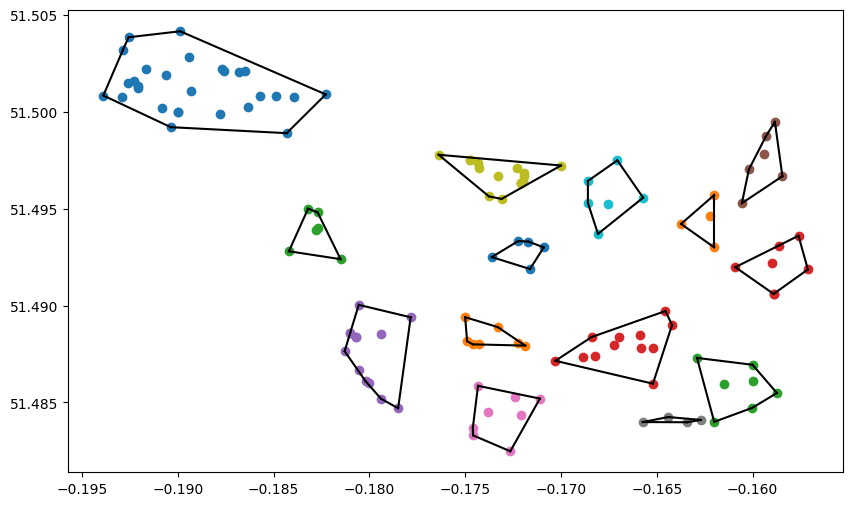

In [9]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#remove noise
remove = kc_wiki[kc_wiki['cluster'] == -1].index
kc_wiki = kc_wiki.drop(remove)
#select only necessary column
db_cl = kc_wiki[["gt_lon",
                   "gt_lat",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(0,14):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["gt_lon", "gt_lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)

Run Bertopic for RBKC

In [10]:
#run model
#extract only wiki data first
#summary_kc = kc_wiki.groupby('cluster')['page_summary'].apply(list)
#summary_kc = pd.DataFrame(summary_kc)
#summary_kc= summary_kc['page_summary'].tolist()
summary_kc = kc_wiki['page_summary'].tolist()
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=2,
                  n_components=4,
                  min_dist=0.0,
                  metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 2,
                        min_samples = 2,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english")
# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        nr_topics=5,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)
topics, probs = topic_model.fit_transform(summary_kc)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-11-25 14:53:43,852 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2024-11-25 14:53:52,476 - BERTopic - Embedding - Completed ✓
2024-11-25 14:53:52,477 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-25 14:54:03,622 - BERTopic - Dimensionality - Completed ✓
2024-11-25 14:54:03,625 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-25 14:54:03,651 - BERTopic - Cluster - Completed ✓
2024-11-25 14:54:03,653 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-25 14:54:03,720 - BERTopic - Representation - Completed ✓
2024-11-25 14:54:03,721 - BERTopic - Topic reduction - Reducing number of topics
2024-11-25 14:54:03,757 - BERTopic - Topic reduction - Reduced number of topics from 27 to 5


Visualise topics

In [11]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8,-1_ground_walton_played_bernini,"[ground, walton, played, bernini, match, bust,...",[Walton Street is a street within central Lond...
1,0,105,0_london_street_kensington_road,"[london, street, kensington, road, chelsea, ho...","[Royal Hospital Road is a street in Chelsea, L..."
2,1,10,1_museum_exhibition_society_design,"[museum, exhibition, society, design, science,...",[The Newcomen Society is an international lear...
3,2,3,2_restaurant_indian_michelin_aubergine,"[restaurant, indian, michelin, aubergine, bomb...",[The Bombay Brasserie is an Indian restaurant ...
4,3,3,3_university_college_close_catholic,"[university, college, close, catholic, london,...",[The Toronto Oratory is a Catholic community o...


In [12]:
bertopic_df = pd.DataFrame(topic_model.get_document_info(summary_kc))

In [13]:
topic_model.visualize_barchart()

In [14]:
topic_model.generate_topic_labels()

['-1_ground_walton_played',
 '0_london_street_kensington',
 '1_museum_exhibition_society',
 '2_restaurant_indian_michelin',
 '3_university_college_close']

In [15]:
#Name the Bertopic topics
def get_bertopic_name(topic):
    if topic == -1:
        return 'Mixed'
    elif topic == 0:
        return 'Renowned roads and streets'
    elif topic == 1:
        return 'Museums and Exhibition'
    elif topic == 2:
        return 'Restaurants'
    else:
        return 'Educational Institutes'
bertopic_df['Bertopic_Wiki'] = bertopic_df['Topic'].apply(get_bertopic_name)

In [ ]:
import gensim
from gensim.utils import simple_preprocess
#preprocess data further to tokenize and remove remaining punctuation using gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(summary_kc))

Evaluate the model

In [16]:
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
documents = pd.DataFrame({"Document": summary_kc,
                          "ID": range(len(summary_kc)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
#words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
#reference: https://github.com/MaartenGr/BERTopic/issues/90
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_uci')
coherence = coherence_model.get_coherence()

coherence

-2.0792123586420406